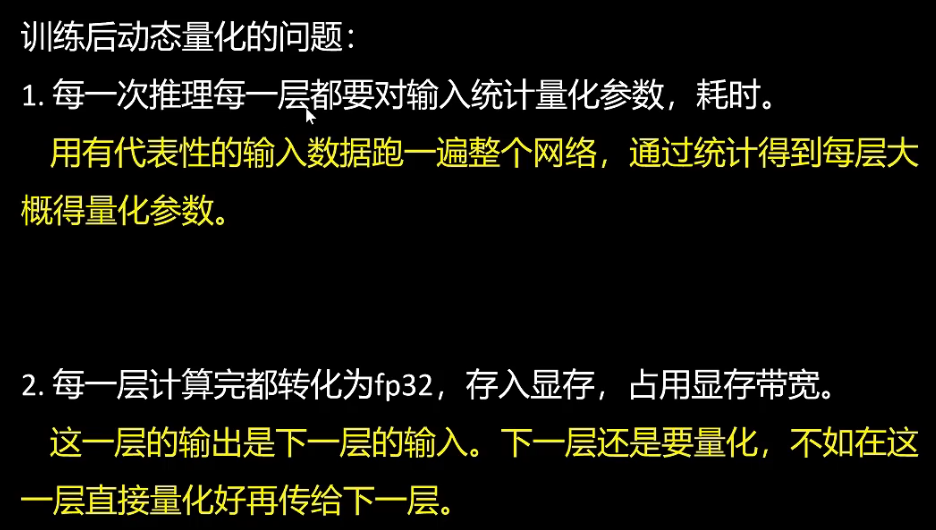

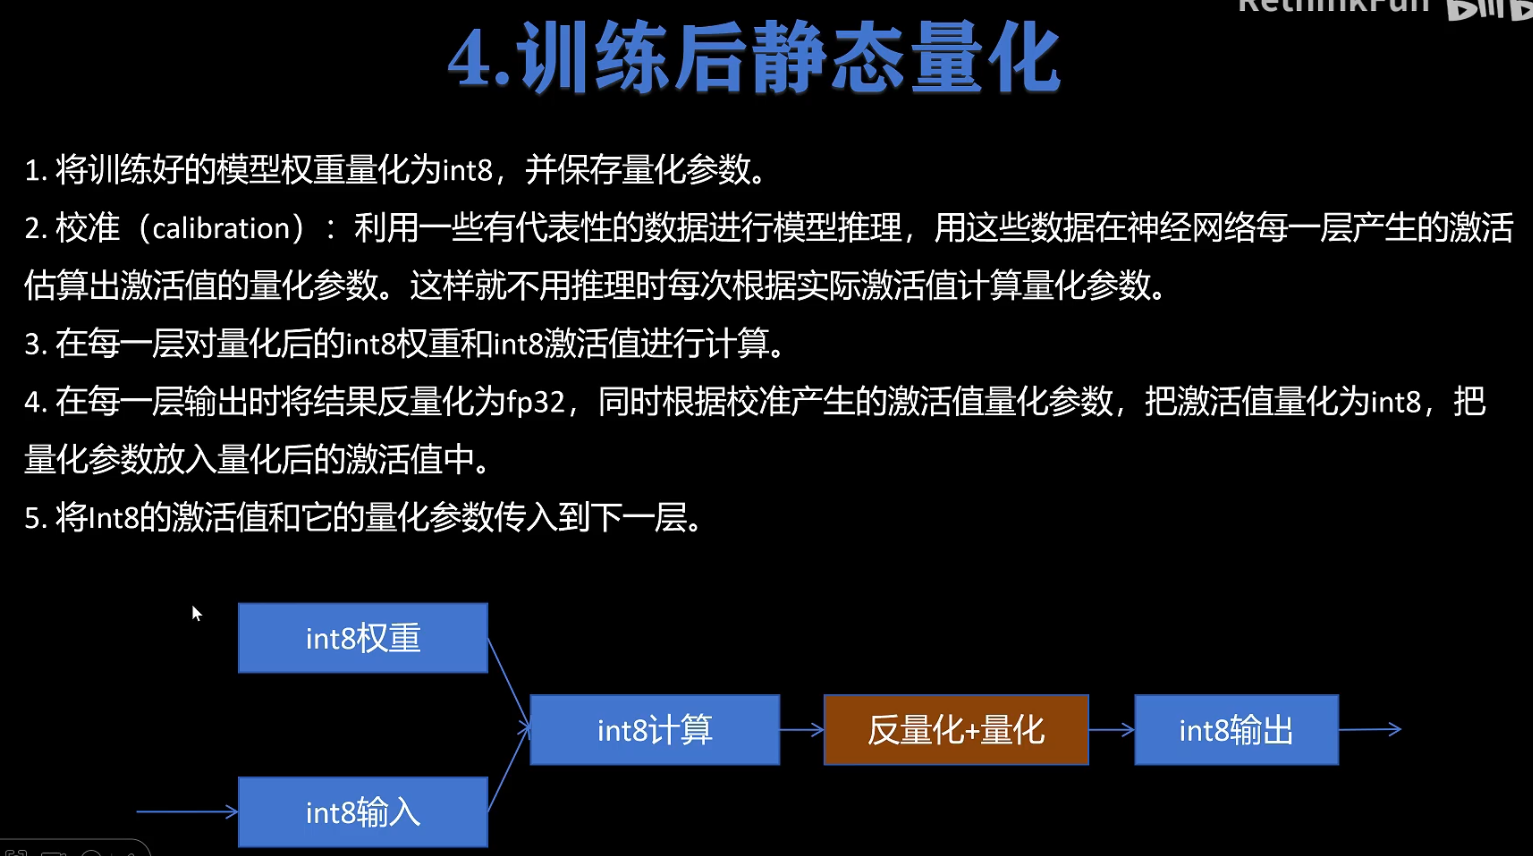

动态量化包括2个阶段：  
（1）量化时将权重量化为int8。  
（2）推理时，输入的激活值是fp32的，动态计算激活对应的scale, zero_point等量化参数，然后将激活值量化为init8，再与int8的权重相乘。  
（3）输出时，将输出从int8反量化为float32。  

与之对比的是静态量化：  
（1）静态量化多一个校准阶段，在校准阶段输入一些代表性input数据，用于统计激活值的最大/最小值，计算激活值的scale, zero_point等量化参数。  
（2）然后是量化阶段，将权重量化为int8，同时保存了激活值的scale, zero_point等量化参数。  
（3）开始推理时，输入的激活值是fp32的，但因为已经有了scale, zero_point等量化参数，可以直接将激活值转换为int8，这样就节省了推理时间。  
（4）输出时，将输出从int8反量化为float32。  

综上所述，动态量化和静态量化的主要区别是激活值的scale, zero_point等量化参数是推理时动态计算的还是在校准阶段已经计算好了。权重都是事先量化成了int8。  

In [1]:
import torch

torch.manual_seed(123)

# QuantStub和DeQuantStub是为了支持静态量化和量化感知训练(Quantization Aware Training)而设计的。它们帮助标记模型中哪些地方应该开始量化，哪些地方应该停止量化。
# 在量化过程中，这些桩会被替换为实际的量化/反量化操作。例如，在推理时，QuantStub会将浮点输入转换为量化表示（通常是 int8），而DeQuantStub则会在输出前将量化表示转回浮点数。
class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.quant = torch.ao.quantization.QuantStub()  # 量化占位符
        self.linear1 = torch.nn.Linear(3, 3, bias=False)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(3, 1, bias=False)
        self.dequant = torch.ao.quantization.DeQuantStub()  # 反量化点位符

    def forward(self, inputs):
        q_inputs = self.quant(inputs)  # 量化
        outputs = self.linear1(q_inputs)
        outputs = self.relu(outputs)
        outputs = self.linear2(outputs)
        f_outputs = self.dequant(outputs)  # 反量化
        return f_outputs

In [2]:
model = MyModel()

In [3]:
model.quant

QuantStub()

In [4]:
model.dequant

DeQuantStub()

In [5]:
# linear1线性层的in_features为3，out_features为3，所以其权重是形状为(3, 3)的矩阵，权重内容如下：
#model.linear1.weight.data
#model.linear1.weight
#model.linear1.weight.dtype
#model.linear1.weight.data.dtype

print(model.linear1.weight.dtype)
print(model.linear1.weight.shape)
print(model.linear1.weight)

torch.float32
torch.Size([3, 3])
Parameter containing:
tensor([[-0.2354,  0.0191, -0.2867],
        [ 0.2177, -0.4919,  0.4232],
        [-0.4196, -0.4590, -0.3648]], requires_grad=True)


In [6]:
# linear2线性层的in_features为3, out_features为1，所以其权重是形状为(1, 3)的矩阵，权重内容如下：
print(model.linear2.weight.dtype)
print(model.linear2.weight.shape)
print(model.linear2.weight)

torch.float32
torch.Size([1, 3])
Parameter containing:
tensor([[ 0.2615, -0.2133,  0.2161]], requires_grad=True)


In [7]:
# 构造训练数据

# weights是一个3行1列的矩阵
weights = torch.tensor([[1.1], [2.2], [3.3]])
print(weights.shape)

# training_features是一个12000行3列的矩阵，代表12000个样本，每个样本有3个特征值。
training_features = torch.randn(12000, 3)
print(training_features.shape)

# 训练样本与权重做矩阵乘法，得到training_labels，其形状为(12000, 1)
training_labels = training_features @ weights
print(training_labels.shape)

torch.Size([3, 1])
torch.Size([12000, 3])
torch.Size([12000, 1])


In [8]:
# 构造测试数据

# 测试数据集形状为(1000, 3)
test_features = torch.randn(1000, 3)
print(test_features.shape)

# 测试数据集标签形状为(1000, 1)
test_labels = test_features @ weights
print(test_labels.shape)

torch.Size([1000, 3])
torch.Size([1000, 1])


In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [10]:
for i in range(100):
    preds = model(training_features)
    loss = torch.nn.functional.mse_loss(preds, training_labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

In [11]:
# 评估float32模型
model.eval()
with torch.no_grad():
    preds = model(test_features)
    mse = torch.nn.functional.mse_loss(preds, test_labels)
    print(f"float32 model testing loss: {mse.item():.3f}")

float32 model testing loss: 0.001


In [12]:
# 配置量化参数
# torch.ao.quantization.get_default_qconfig('x86')返回一个针对x86架构优化的默认量化配置。这包括了量化算法的选择和参数设置，适用于在x86 CPU上运行的模型。
model.qconfig = torch.ao.quantization.get_default_qconfig('x86')

# 模块融合，将linear1和relu融合为一个模块
# torch.ao.quantization.fuse_modules(model, [['linear1', 'relu']])

# 准备模型进行量化
# torch.ao.quantization.prepare(model)修改了模型，插入了必要的观察者(observer)模块，用于收集后续校准过程中所需的统计信息（如激活张量的范围）。
model_prepared = torch.ao.quantization.prepare(model)

# 这是静态量化的一个关键步骤，通过将一些代表性数据（如test_features）传入模型，实际执行一次或多次前向传播以收集这些统计信息，计算激活值的scale, zero_point等量化参数。
model_prepared(test_features)

# 执行量化，将模型权重转换为int8，同时也保存了激活值的scale, zero_point等量化参数。
model_int8 = torch.ao.quantization.convert(model_prepared)

/home/haoyu/anaconda3/envs/INT8/lib/python3.12/site-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [13]:
print("float32 model linear1 parameter:\n", model.linear1.weight)
print("\nint8 model linear1 parameter (int8):\n", torch.int_repr(model_int8.linear1.weight()))

# 查看量化参数，可以看到量化策略是per channel量化，scale有3个。
print("\nint8 model linear1 parameter:\n", model_int8.linear1.weight())

float32 model linear1 parameter:
 Parameter containing:
tensor([[ 0.7387,  1.4585,  2.1794],
        [-0.7526, -1.5223, -2.0909],
        [-0.4093, -0.6998, -1.4874]], requires_grad=True)

int8 model linear1 parameter (int8):
 tensor([[  43,   85,  127],
        [ -46,  -93, -127],
        [ -35,  -60, -128]], dtype=torch.int8)

int8 model linear1 parameter:
 tensor([[ 0.7350,  1.4529,  2.1708],
        [-0.7544, -1.5251, -2.0827],
        [-0.4083, -0.6999, -1.4932]], size=(3, 3), dtype=torch.qint8,
       quantization_scheme=torch.per_channel_affine,
       scale=tensor([0.0171, 0.0164, 0.0117], dtype=torch.float64),
       zero_point=tensor([0, 0, 0]), axis=0)


In [14]:
# 评估int8模型
with torch.no_grad():
    preds = model_int8(test_features)
    mse = torch.nn.functional.mse_loss(preds, test_labels)
    print(f"int8 model testing loss: {mse.item():.3f}")

int8 model testing loss: 0.009
